# Análise de Regressão - Predição de Dias de Atraso

Este projeto tem como objetivo desenvolver e avaliar modelos de regressão capazes de prever o número de dias de atraso em pagamentos de clientes, utilizando dados históricos de transações financeiras, informações cadastrais e características dos clientes.

O processo envolve:
- Carregamento e exploração de múltiplas bases de dados, incluindo dados cadastrais, informações financeiras e registros de pagamentos.
- Análise exploratória para compreensão das variáveis, identificação de padrões e tratamento de valores ausentes.
- Engenharia de features, incluindo criação de variáveis temporais, categóricas e numéricas relevantes para o problema.
- Treinamento e avaliação de diferentes modelos de regressão (Linear, Ridge, Lasso, Random Forest), com validação cruzada e análise de métricas de desempenho (RMSE, MAE, R²).
- Interpretação dos resultados e análise da importância das variáveis para o modelo.

O notebook está estruturado para permitir fácil replicação dos experimentos e adaptação para novos conjuntos de dados ou abordagens de modelagem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Carregamento e Exploração dos Dados

In [2]:
# Carregamento dos dados
data_folder = './data'
files = [
    'base_cadastral.csv',
    'base_info.csv',
    'base_pagamentos_desenvolvimento.csv',
    'base_pagamentos_teste.csv'
]

dfs = {}
for file in files:
    path = os.path.join(data_folder, file)
    try:
        dfs[file] = pd.read_csv(path, sep=';')
        print(f'Loaded {file} with shape {dfs[file].shape}')
    except Exception as e:
        print(f'Error loading {file}: {e}')

# Criando variáveis para facilitar o acesso
df_cadastral = dfs['base_cadastral.csv']
df_info = dfs['base_info.csv']
df_dev = dfs['base_pagamentos_desenvolvimento.csv']
df_teste = dfs['base_pagamentos_teste.csv']

Loaded base_cadastral.csv with shape (1315, 8)
Loaded base_info.csv with shape (24401, 4)
Loaded base_pagamentos_desenvolvimento.csv with shape (77414, 7)
Loaded base_pagamentos_teste.csv with shape (12275, 6)


## 2. Análise Exploratória das Bases

In [3]:
print("=== BASE CADASTRAL ===")
print(f"Shape: {df_cadastral.shape}")
print("\nPrimeiras linhas:")
display(df_cadastral.head())
print("\nInformações dos dados:")
print(df_cadastral.info())
print("\nEstatísticas descritivas:")
display(df_cadastral.describe())

=== BASE CADASTRAL ===
Shape: (1315, 8)

Primeiras linhas:


,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,NaN,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,NaN,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372198,2017-08-06,49,NaN,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236008,2011-02-14,88,NaN,Serviços,GMAIL,GRANDE,62



Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_CLIENTE           1315 non-null   int64 
 1   DATA_CADASTRO        1315 non-null   object
 2   DDD                  1078 non-null   object
 3   FLAG_PF              66 non-null     object
 4   SEGMENTO_INDUSTRIAL  1232 non-null   object
 5   DOMINIO_EMAIL        1285 non-null   object
 6   PORTE                1274 non-null   object
 7   CEP_2_DIG            1315 non-null   object
dtypes: int64(1), object(7)
memory usage: 82.3+ KB
None

Estatísticas descritivas:


,ID_CLIENTE
count,1.315000e+03
mean,4.637945e+18
std,2.667894e+18
min,8.784237e+15
25%,2.307709e+18
50%,4.714188e+18
75%,6.973809e+18
max,9.206031e+18


In [4]:
print("=== BASE PAGAMENTOS DESENVOLVIMENTO ===")
print(f"Shape: {df_dev.shape}")
print("\nPrimeiras linhas:")
display(df_dev.head())
print("\nInformações dos dados:")
print(df_dev.info())
print("\nEstatísticas descritivas:")
display(df_dev.describe())

=== BASE PAGAMENTOS DESENVOLVIMENTO ===
Shape: (77414, 7)

Primeiras linhas:


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99



Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_CLIENTE              77414 non-null  int64  
 1   SAFRA_REF               77414 non-null  object 
 2   DATA_EMISSAO_DOCUMENTO  77414 non-null  object 
 3   DATA_PAGAMENTO          77414 non-null  object 
 4   DATA_VENCIMENTO         77414 non-null  object 
 5   VALOR_A_PAGAR           76244 non-null  float64
 6   TAXA                    77414 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 4.1+ MB
None

Estatísticas descritivas:


,ID_CLIENTE,VALOR_A_PAGAR,TAXA
count,7.741400e+04,7.624400e+04,77414.000000
mean,4.662270e+18,4.659078e+04,6.789623
std,2.665719e+18,4.643393e+04,1.798225
min,8.784237e+15,1.000000e-01,4.990000
25%,2.369365e+18,1.876536e+04,5.990000
50%,4.817817e+18,3.475869e+04,5.990000
75%,6.969349e+18,6.093384e+04,6.990000
max,9.206031e+18,4.400000e+06,11.990000


In [5]:
print("=== BASE INFO ===")
print(f"Shape: {df_info.shape}")
print("\nPrimeiras linhas:")
display(df_info.head())
print("\nInformações dos dados:")
print(df_info.info())
print("\nEstatísticas descritivas:")
display(df_info.describe())

=== BASE INFO ===
Shape: (24401, 4)

Primeiras linhas:


,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-09,16913.0,NaN
1,8274986328479596038,2018-09,106430.0,141.0
2,345447888460137901,2018-09,707439.0,99.0
3,1003144834589372198,2018-09,239659.0,96.0
4,324916756972236008,2018-09,203123.0,103.0



Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_CLIENTE          24401 non-null  int64  
 1   SAFRA_REF           24401 non-null  object 
 2   RENDA_MES_ANTERIOR  23684 non-null  float64
 3   NO_FUNCIONARIOS     23149 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 762.7+ KB
None

Estatísticas descritivas:


,ID_CLIENTE,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
count,2.440100e+04,2.368400e+04,23149.000000
mean,4.668214e+18,2.887514e+05,117.799646
std,2.669294e+18,2.115948e+05,21.464574
min,8.784237e+15,1.050000e+02,0.000000
25%,2.347029e+18,1.338662e+05,106.000000
50%,4.795153e+18,2.409985e+05,118.000000
75%,7.061869e+18,3.925018e+05,131.000000
max,9.206031e+18,1.682759e+06,198.000000


In [6]:
print("=== BASE PAGAMENTOS TESTE ===")
print(f"Shape: {df_teste.shape}")
print("\nPrimeiras linhas:")
display(df_teste.head())
print("\nInformações dos dados:")
print(df_teste.info())
print("\nEstatísticas descritivas:")
display(df_teste.describe())

=== BASE PAGAMENTOS TESTE ===
Shape: (12275, 6)

Primeiras linhas:


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99



Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12275 entries, 0 to 12274
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_CLIENTE              12275 non-null  int64  
 1   SAFRA_REF               12275 non-null  object 
 2   DATA_EMISSAO_DOCUMENTO  12275 non-null  object 
 3   DATA_VENCIMENTO         12275 non-null  object 
 4   VALOR_A_PAGAR           12144 non-null  float64
 5   TAXA                    12275 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 575.5+ KB
None

Estatísticas descritivas:


,ID_CLIENTE,VALOR_A_PAGAR,TAXA
count,1.227500e+04,12144.000000,12275.000000
mean,4.670820e+18,65883.258575,6.807271
std,2.667868e+18,55919.404970,1.835351
min,8.784237e+15,6.900000,4.990000
25%,2.308217e+18,26712.335000,5.990000
50%,4.850936e+18,49665.210000,5.990000
75%,6.964109e+18,87029.362500,6.990000
max,9.206031e+18,830000.000000,11.990000


## 3. Criação da Variável Target (INADIMPLENTE)
Variável target: INADIMPLENTE

In [7]:
# Convertendo colunas de data para datetime
df_dev['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_dev['DATA_EMISSAO_DOCUMENTO'])
df_dev['DATA_PAGAMENTO'] = pd.to_datetime(df_dev['DATA_PAGAMENTO'])
df_dev['DATA_VENCIMENTO'] = pd.to_datetime(df_dev['DATA_VENCIMENTO'])

# Calculando dias de atraso (VARIÁVEL TARGET)
dias_atraso = ((df_dev['DATA_PAGAMENTO'] - df_dev['DATA_VENCIMENTO']).dt.days)

# Criando categoria de inadimplência para análise (1 = inadimplente, 0 = adimplente)
df_dev['INADIMPLENTE'] = (dias_atraso >= 5).astype(int)

print("Distribuição da categoria de inadimplência:")
print(df_dev['INADIMPLENTE'].value_counts())
print(f"\nTaxa de inadimplência: {df_dev['INADIMPLENTE'].mean():.2%}")

print("\nAnálise da distribuição dos dias de atraso:")
print(f"Pagamentos em dia (≤ 0 dias): {(dias_atraso <= 0).sum():,} ({(dias_atraso <= 0).mean():.1%})")
print(f"Pagamentos com 1-4 dias de atraso: {((dias_atraso > 0) & (dias_atraso < 5)).sum():,} ({((dias_atraso > 0) & (dias_atraso < 5)).mean():.1%})")
print(f"Pagamentos com 5+ dias de atraso: {(dias_atraso >= 5).sum():,} ({(dias_atraso >= 5).mean():.1%})")

Distribuição da categoria de inadimplência:
INADIMPLENTE
0    71978
1     5436
Name: count, dtype: int64

Taxa de inadimplência: 7.02%

Análise da distribuição dos dias de atraso:
Pagamentos em dia (≤ 0 dias): 68,648 (88.7%)
Pagamentos com 1-4 dias de atraso: 3,330 (4.3%)
Pagamentos com 5+ dias de atraso: 5,436 (7.0%)


In [8]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_CLIENTE              77414 non-null  int64         
 1   SAFRA_REF               77414 non-null  object        
 2   DATA_EMISSAO_DOCUMENTO  77414 non-null  datetime64[ns]
 3   DATA_PAGAMENTO          77414 non-null  datetime64[ns]
 4   DATA_VENCIMENTO         77414 non-null  datetime64[ns]
 5   VALOR_A_PAGAR           76244 non-null  float64       
 6   TAXA                    77414 non-null  float64       
 7   INADIMPLENTE            77414 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(1)
memory usage: 4.7+ MB


## 4. Engenharia de Features

In [9]:
df_dev["TAXA"].describe()

count    77414.000000
mean         6.789623
std          1.798225
min          4.990000
25%          5.990000
50%          5.990000
75%          6.990000
max         11.990000
Name: TAXA, dtype: float64

In [10]:
df_dev["VALOR_A_PAGAR"].describe()

count    7.624400e+04
mean     4.659078e+04
std      4.643393e+04
min      1.000000e-01
25%      1.876536e+04
50%      3.475869e+04
75%      6.093384e+04
max      4.400000e+06
Name: VALOR_A_PAGAR, dtype: float64

count    7.624400e+04
mean     4.659078e+04
std      4.643393e+04
min      1.000000e-01
25%      1.876536e+04
50%      3.475869e+04
75%      6.093384e+04
max      4.400000e+06
Name: VALOR_A_PAGAR, dtype: float64
Skewness: 16.41


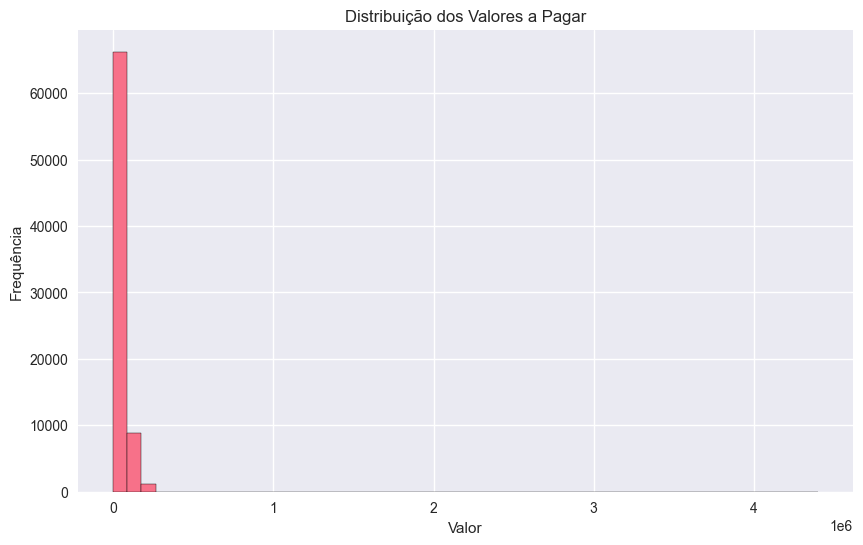

In [11]:
# Verificar distribuição
print(df_dev['VALOR_A_PAGAR'].describe())
print(f"Skewness: {df_dev['VALOR_A_PAGAR'].skew():.2f}")

# Histograma para visualizar distribuição
plt.figure(figsize=(10, 6))
plt.hist(df_dev['VALOR_A_PAGAR'], bins=50, edgecolor='black')
plt.title('Distribuição dos Valores a Pagar')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

count    77414.000000
mean         6.789623
std          1.798225
min          4.990000
25%          5.990000
50%          5.990000
75%          6.990000
max         11.990000
Name: TAXA, dtype: float64
Skewness: 1.61


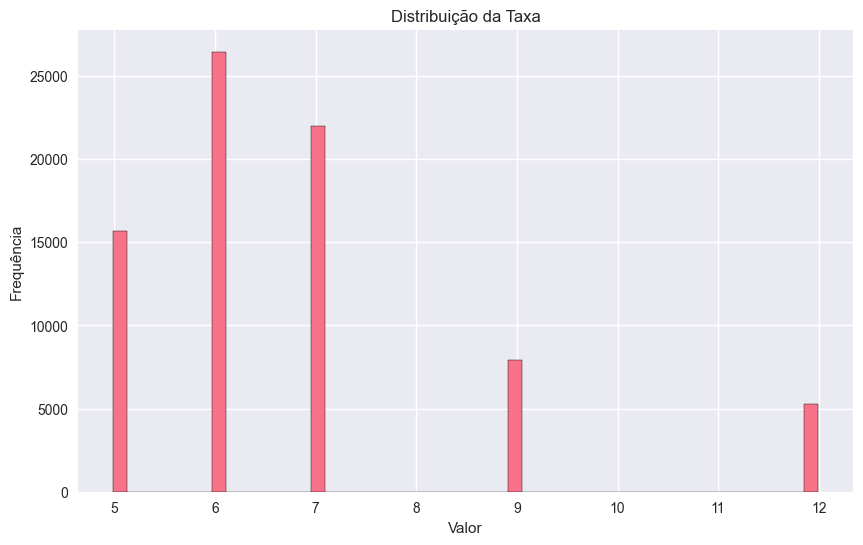

In [12]:
# Verificar distribuição
print(df_dev['TAXA'].describe())
print(f"Skewness: {df_dev['TAXA'].skew():.2f}")

# Histograma para visualizar distribuição
plt.figure(figsize=(10, 6))
plt.hist(df_dev['TAXA'], bins=50, edgecolor='black')
plt.title('Distribuição da Taxa')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

In [13]:
# Features de data - Extração de componentes temporais
df_dev['MES_VENCIMENTO'] = df_dev['DATA_VENCIMENTO'].dt.month
df_dev['ANO_VENCIMENTO'] = df_dev['DATA_VENCIMENTO'].dt.year
df_dev['DIA_SEMANA_VENCIMENTO'] = df_dev['DATA_VENCIMENTO'].dt.dayofweek

# Features de valor - Criação de categorias
df_dev['VALOR_CATEGORIA'] = pd.qcut(df_dev['VALOR_A_PAGAR'],
                                    q=5,
                                    duplicates='drop')

df_dev['TAXA_CATEGORIA'] = pd.qcut(df_dev['TAXA'], 
                                   q=4,
                                   duplicates='drop')

In [14]:
df_dev['VALOR_CATEGORIA'].unique()

[(27516.73, 42552.38], (16817.804, 27516.73], (0.099, 16817.804], (42552.38, 70437.208], (70437.208, 4400000.0], NaN]
Categories (5, interval[float64, right]): [(0.099, 16817.804] < (16817.804, 27516.73] < (27516.73, 42552.38] < (42552.38, 70437.208] < (70437.208, 4400000.0]]

In [15]:
df_dev['VALOR_CATEGORIA'] = df_dev['VALOR_CATEGORIA'].cat.rename_categories(["Médio", "Baixo", "Muito Baixo", "Alto", "Muito Alto"])
df_dev['VALOR_CATEGORIA']

0        Muito Baixo
1              Baixo
2              Baixo
3              Médio
4              Baixo
            ...     
77409     Muito Alto
77410    Muito Baixo
77411          Baixo
77412     Muito Alto
77413          Baixo
Name: VALOR_CATEGORIA, Length: 77414, dtype: category
Categories (5, object): ['Médio' < 'Baixo' < 'Muito Baixo' < 'Alto' < 'Muito Alto']

In [16]:
df_dev['TAXA_CATEGORIA'].unique()

[(5.99, 6.99], (4.989, 5.99], (6.99, 11.99]]
Categories (3, interval[float64, right]): [(4.989, 5.99] < (5.99, 6.99] < (6.99, 11.99]]

In [17]:
df_dev['TAXA_CATEGORIA'] = df_dev['TAXA_CATEGORIA'].cat.rename_categories(["Médio", "Baixo", "Alto"])
df_dev['TAXA_CATEGORIA']

0        Baixo
1        Baixo
2        Baixo
3        Baixo
4        Baixo
         ...  
77409    Médio
77410    Médio
77411    Médio
77412    Baixo
77413    Médio
Name: TAXA_CATEGORIA, Length: 77414, dtype: category
Categories (3, object): ['Médio' < 'Baixo' < 'Alto']

In [18]:
print("Features criadas com sucesso!")
print(f"Shape final: {df_dev.shape}")

Features criadas com sucesso!
Shape final: (77414, 13)


In [19]:
# Merge com dados cadastrais
df_merged = df_dev.merge(df_cadastral, on='ID_CLIENTE', how='left')

# Merge com dados de informação mensal
df_merged = df_merged.merge(df_info, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')

print(f"Shape após merge: {df_merged.shape}")
print(f"Colunas disponíveis: {list(df_merged.columns)}")

# Verificando missing values após merge
print("\nMissing values após merge:")
missing_data = df_merged.isnull().sum()
print(missing_data[missing_data > 0])

Shape após merge: (77414, 22)
Colunas disponíveis: ['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO', 'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'INADIMPLENTE', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA', 'DATA_CADASTRO', 'DDD', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']

Missing values após merge:
VALOR_A_PAGAR           1170
VALOR_CATEGORIA         1170
DDD                     7414
FLAG_PF                77195
SEGMENTO_INDUSTRIAL     1417
DOMINIO_EMAIL            898
PORTE                   2476
RENDA_MES_ANTERIOR      6132
NO_FUNCIONARIOS         7587
dtype: int64


In [20]:
# Remover linhas com TODOS os valores faltantes
df_merged = df_merged.dropna(how='all')
df_merged

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,INADIMPLENTE,MES_VENCIMENTO,ANO_VENCIMENTO,DIA_SEMANA_VENCIMENTO,VALOR_CATEGORIA,TAXA_CATEGORIA,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,9,2018,3,Muito Baixo,Baixo,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,0,9,2018,0,Baixo,Baixo,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,0,9,2018,0,Baixo,Baixo,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,1,10,2018,4,Médio,Baixo,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,9,2018,3,Baixo,Baixo,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77409,2951563549197799278,2021-06,2021-06-30,2021-07-16,2021-07-16,89980.00,5.99,0,7,2021,4,Muito Alto,Médio,2000-08-15,11,NaN,Comércio,AOL,PEQUENO,13,280343.0,161.0
77410,5220206408301580591,2021-06,2021-06-30,2021-08-16,2021-08-16,42239.00,5.99,0,8,2021,0,Muito Baixo,Médio,2021-04-08,19,NaN,Indústria,GMAIL,GRANDE,25,235315.0,87.0
77411,5860276371789140450,2021-06,2021-06-30,2021-07-16,2021-07-16,20921.50,5.99,0,7,2021,4,Baixo,Médio,2011-02-15,91,NaN,Serviços,HOTMAIL,GRANDE,67,100006.0,NaN
77412,2814790209436551216,2021-06,2021-06-30,2021-07-16,2021-07-16,90231.05,6.99,0,7,2021,4,Muito Alto,Baixo,2021-05-13,(1,NaN,Serviços,YAHOO,MEDIO,14,NaN,NaN


In [21]:
# Dado a quantidade de valores faltantes na coluna 'FLAG_PF', vamos tratá-las, dado que é uma coluna importante para a
# análise e onde os valores faltantes representam o valor booleano False.
df_merged['FLAG_PF'] = df_merged['FLAG_PF'].apply(lambda x: True if x == 'X' else False)

In [22]:
df_merged.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,INADIMPLENTE,MES_VENCIMENTO,ANO_VENCIMENTO,DIA_SEMANA_VENCIMENTO,VALOR_CATEGORIA,TAXA_CATEGORIA,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,9,2018,3,Muito Baixo,Baixo,2013-08-22,99,False,Serviços,YAHOO,PEQUENO,65,NaN,NaN
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,0,9,2018,0,Baixo,Baixo,2013-08-22,99,False,Serviços,YAHOO,PEQUENO,65,NaN,NaN
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,0,9,2018,0,Baixo,Baixo,2013-08-22,99,False,Serviços,YAHOO,PEQUENO,65,NaN,NaN
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,1,10,2018,4,Médio,Baixo,2013-08-22,99,False,Serviços,YAHOO,PEQUENO,65,NaN,NaN
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,9,2018,3,Baixo,Baixo,2013-08-22,99,False,Serviços,YAHOO,PEQUENO,65,NaN,NaN


In [23]:
df_merged.dropna(subset=['VALOR_A_PAGAR'], inplace=True)

## 5. Análise de Correlação e Distribuição

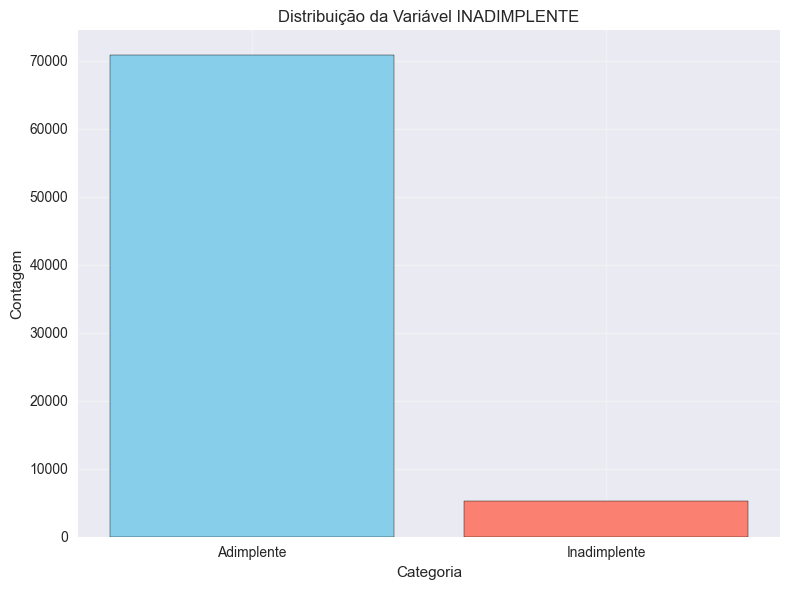

In [24]:
# Análise da distribuição da variável INADIMPLENTE
fig, ax = plt.subplots(figsize=(8, 6))

# Contagem de valores
inadimplente_counts = df_merged['INADIMPLENTE'].value_counts()

# Gráfico de barras
ax.bar(inadimplente_counts.index, inadimplente_counts.values, color=['skyblue', 'salmon'], edgecolor='black')
ax.set_xticks(inadimplente_counts.index)
ax.set_xticklabels(['Adimplente', 'Inadimplente'])
ax.set_title('Distribuição da Variável INADIMPLENTE')
ax.set_xlabel('Categoria')
ax.set_ylabel('Contagem')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

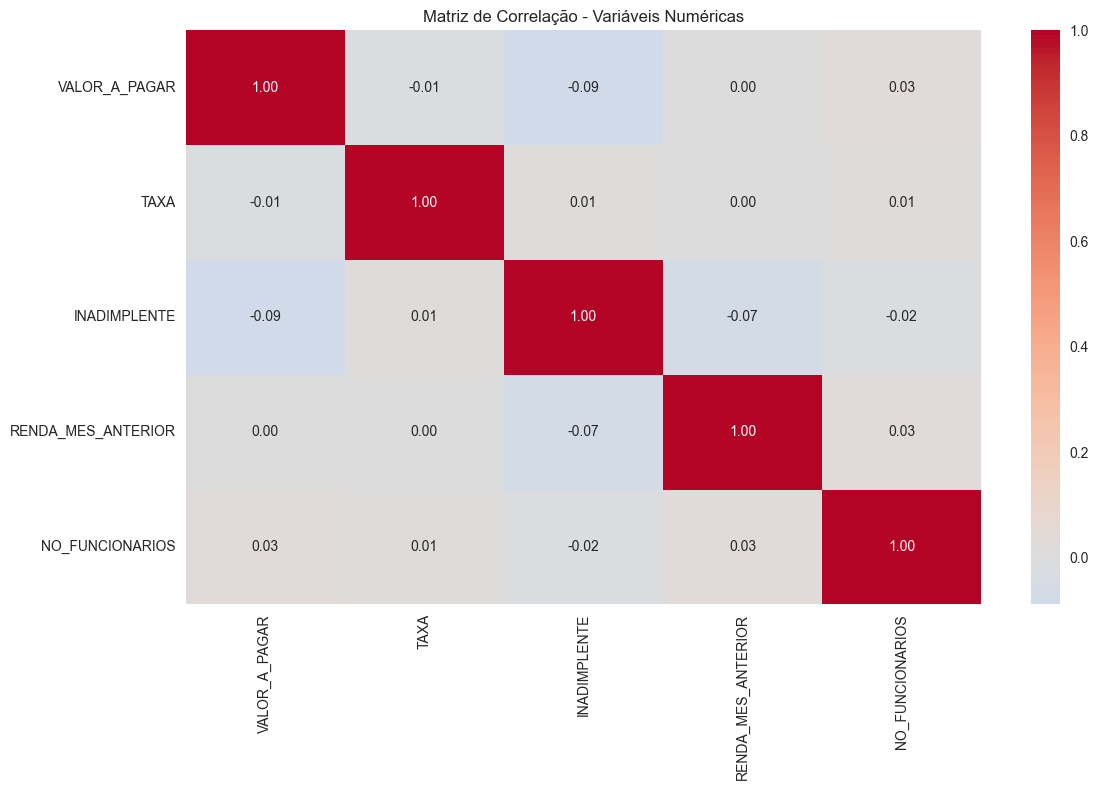

In [25]:
# Análise de correlação entre variáveis numéricas
numeric_columns = df_merged.select_dtypes(include=['int64', 'float64']).columns.drop('ID_CLIENTE')
correlation_matrix = df_merged[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.tight_layout()
plt.show()

> Aqui podemos observar informações relevantes:
> 1. As variáveis mais correlacionadas com a variável target são 'VALOR_A_PAGAR' e 'RENDA_MES_ANTERIOR';
> 2. As variáveis 'TAXA' e 'NO_FUNCIONARIOS' apresentam uma correlação muito baixa, inferindo que não há relação significativa entre elas;
> 3. Todas as variáveis numéricas apresentam uma correlação quase nula ou baixa com a variável target.

C:\Users\olive\AppData\Local\Temp\ipykernel_30616\291555143.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_df.index, y=correlation_df.mean(axis=1), palette='viridis')


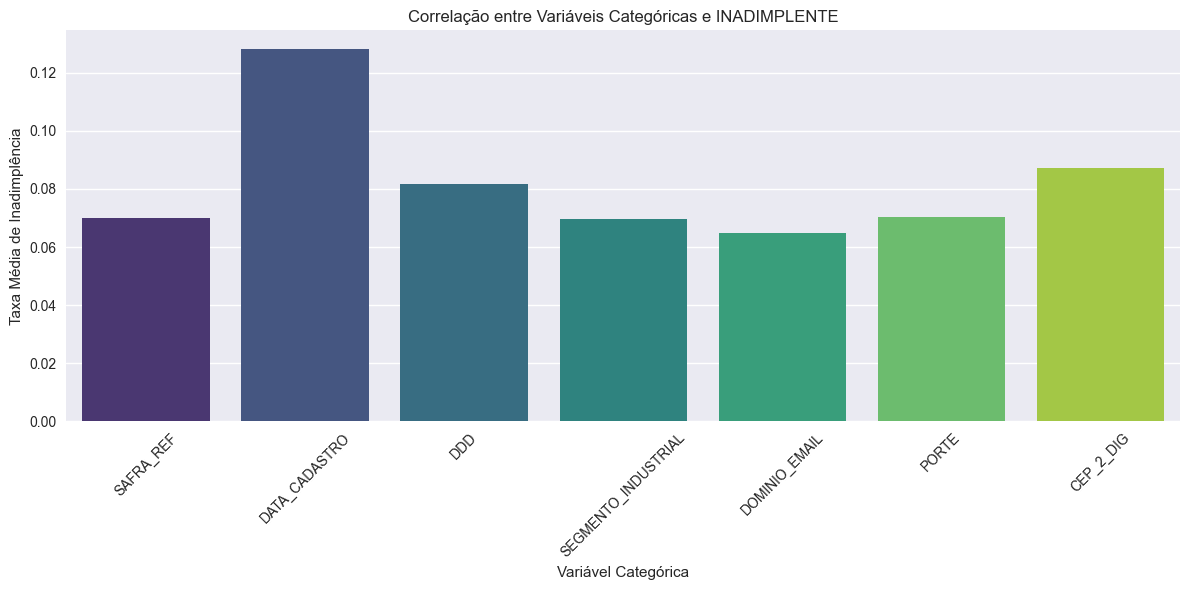

In [26]:
# Análise de correlação entre variáveis categóricas e a variável alvo INADIMPLENTE
categorical_columns = df_merged.select_dtypes(include=['object']).columns
correlation_categorical = {}
for col in categorical_columns:
    if col != 'INADIMPLENTE':
        correlation = df_merged.groupby(col)['INADIMPLENTE'].mean()
        correlation_categorical[col] = correlation
# Criando DataFrame para visualização
correlation_df = pd.DataFrame(correlation_categorical).T

# Plotando a correlação entre variáveis categóricas e INADIMPLENTE
plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_df.index, y=correlation_df.mean(axis=1), palette='viridis')
plt.xticks(rotation=45)
plt.title('Correlação entre Variáveis Categóricas e INADIMPLENTE')
plt.xlabel('Variável Categórica')
plt.ylabel('Taxa Média de Inadimplência')
plt.tight_layout()
plt.show()

> Apesar de mostrarem maior correlação perante as demais variáveis, as features "DATA_CADASTRO" e "CEP_2_DIG" não são consideradas relevantes para o modelo, pois não possuem uma relação direta com a variável target. Assim como a variável "DOMINIO_EMAIL", que não apresenta correlação significativa com a variável target.

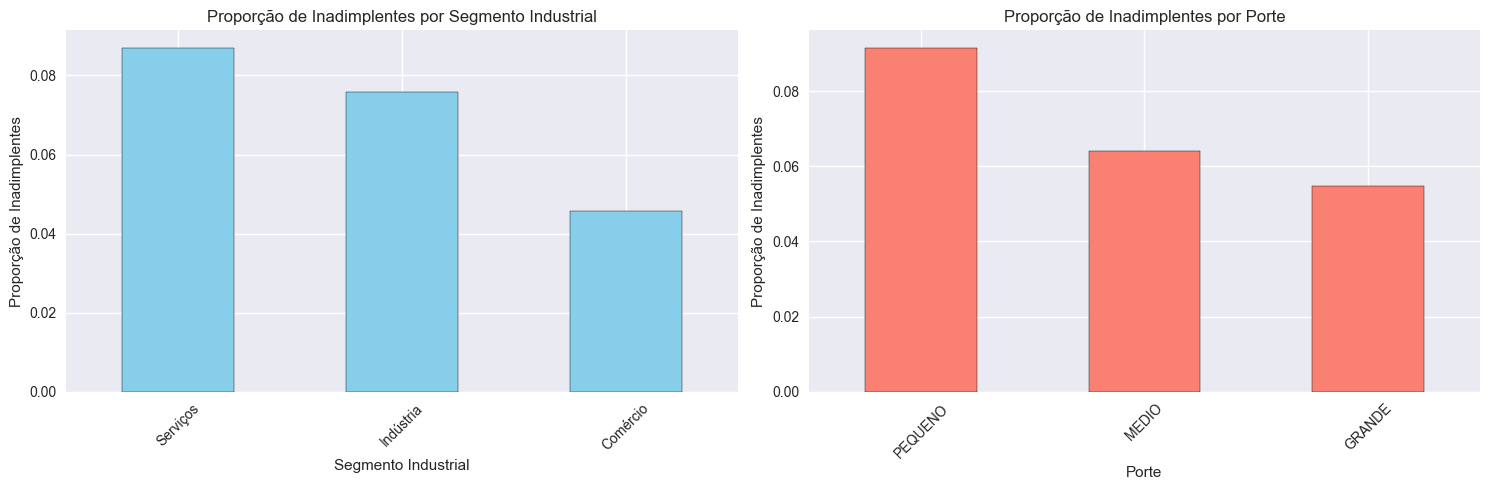

In [27]:
# Análise da proporção de inadimplentes por segmento industrial e porte
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Proporção de inadimplentes por segmento industrial
segmento_inadimplente = df_merged.groupby('SEGMENTO_INDUSTRIAL')['INADIMPLENTE'].mean().sort_values(ascending=False)
segmento_inadimplente.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Proporção de Inadimplentes por Segmento Industrial')
axes[0].set_xlabel('Segmento Industrial')
axes[0].set_ylabel('Proporção de Inadimplentes')
axes[0].tick_params(axis='x', rotation=45)

# Proporção de inadimplentes por porte
porte_inadimplente = df_merged.groupby('PORTE')['INADIMPLENTE'].mean().sort_values(ascending=False)
porte_inadimplente.plot(kind='bar', ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Proporção de Inadimplentes por Porte')
axes[1].set_xlabel('Porte')
axes[1].set_ylabel('Proporção de Inadimplentes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

> Aqui, é possível observar que os segmentos de Serviços e Indústria apresentam uma maior média de dias de atraso, enquanto o segmento de Comércio apresenta uma média menor. Isso pode indicar que os clientes dos segmentos de Serviços e Indústria enfrentam mais dificuldades financeiras ou operacionais que impactam seus pagamentos.
>
> Além disso, a análise de correlação entre as variáveis por Porte da empresa mostra que o porte da empresa também influencia a quantidade de dias de atraso, com empresas de grande porte apresentando uma média menor de dias de atraso em comparação com as de pequeno e médio porte.

C:\Users\olive\AppData\Local\Temp\ipykernel_30616\520331189.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmento_inadimplente = df_merged.groupby('VALOR_CATEGORIA')['INADIMPLENTE'].mean().sort_values(ascending=False)
C:\Users\olive\AppData\Local\Temp\ipykernel_30616\520331189.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  porte_inadimplente = df_merged.groupby('TAXA_CATEGORIA')['INADIMPLENTE'].mean().sort_values(ascending=False)


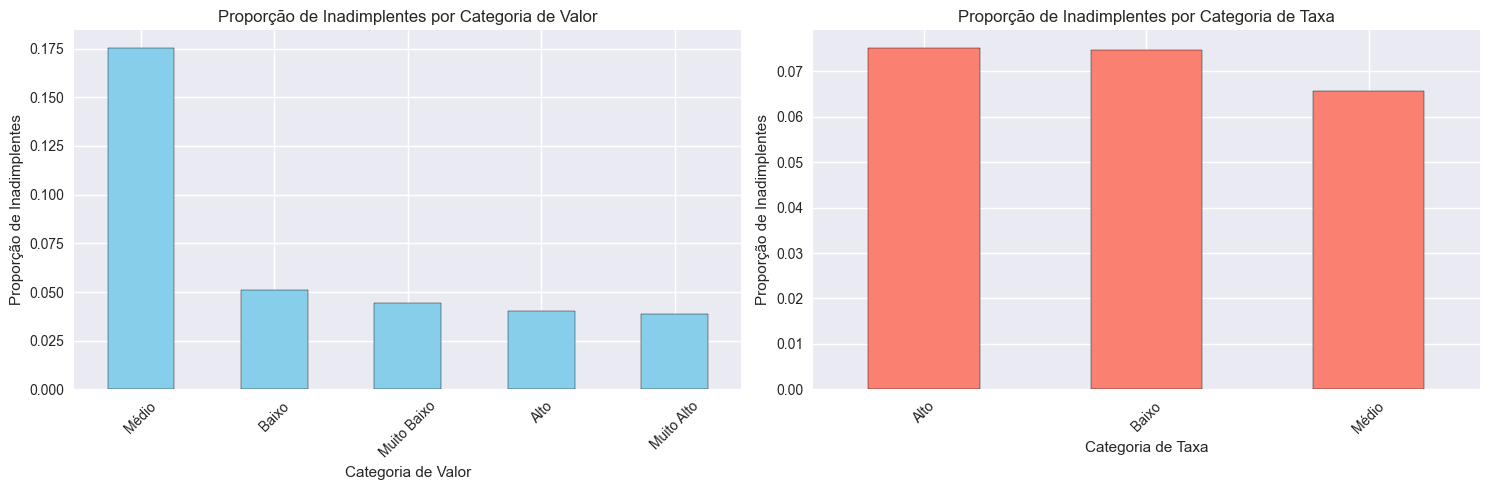

In [28]:
# Análise da proporção de inadimplentes por segmento industrial e porte
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Proporção de inadimplentes por segmento industrial
segmento_inadimplente = df_merged.groupby('VALOR_CATEGORIA')['INADIMPLENTE'].mean().sort_values(ascending=False)
segmento_inadimplente.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Proporção de Inadimplentes por Categoria de Valor')
axes[0].set_xlabel('Categoria de Valor')
axes[0].set_ylabel('Proporção de Inadimplentes')
axes[0].tick_params(axis='x', rotation=45)

# Proporção de inadimplentes por porte
porte_inadimplente = df_merged.groupby('TAXA_CATEGORIA')['INADIMPLENTE'].mean().sort_values(ascending=False)
porte_inadimplente.plot(kind='bar', ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Proporção de Inadimplentes por Categoria de Taxa')
axes[1].set_xlabel('Categoria de Taxa')
axes[1].set_ylabel('Proporção de Inadimplentes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Preparação dos Dados para Machine Learning

In [29]:
# Selecionando features para o modelo (INADIMPLENTE como target)
features_numericas = ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO', 'RENDA_MES_ANTERIOR']
features_categoricas = ['SEGMENTO_INDUSTRIAL', 'PORTE', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA']

# Criando dataset para modelagem (INADIMPLENTE como target)
df_model = df_merged[features_numericas + features_categoricas + ['INADIMPLENTE']].copy()

print(f"Shape do dataset para modelagem: {df_model.shape}")
print(f"Features numéricas: {features_numericas}")
print(f"Features categóricas: {features_categoricas}")
print("Variável target: INADIMPLENTE")

Shape do dataset para modelagem: (76244, 11)
Features numéricas: ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO', 'RENDA_MES_ANTERIOR']
Features categóricas: ['SEGMENTO_INDUSTRIAL', 'PORTE', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA']
Variável target: INADIMPLENTE


In [30]:
# Tratamento de missing values
print("Missing values antes do tratamento:")
print(df_model.isnull().sum())

# Para variáveis numéricas: imputação com mediana
imputer_numerico = SimpleImputer(strategy='median')
df_model[features_numericas] = imputer_numerico.fit_transform(df_model[features_numericas])

# Para variáveis categóricas: imputação com moda
imputer_categorico = SimpleImputer(strategy='most_frequent')
df_model[features_categoricas] = imputer_categorico.fit_transform(df_model[features_categoricas])

print("\nMissing values após o tratamento:")
print(df_model.isnull().sum())

Missing values antes do tratamento:
VALOR_A_PAGAR               0
TAXA                        0
MES_VENCIMENTO              0
ANO_VENCIMENTO              0
DIA_SEMANA_VENCIMENTO       0
RENDA_MES_ANTERIOR       6034
SEGMENTO_INDUSTRIAL      1402
PORTE                    2444
VALOR_CATEGORIA             0
TAXA_CATEGORIA              0
INADIMPLENTE                0
dtype: int64

Missing values após o tratamento:
VALOR_A_PAGAR            0
TAXA                     0
MES_VENCIMENTO           0
ANO_VENCIMENTO           0
DIA_SEMANA_VENCIMENTO    0
RENDA_MES_ANTERIOR       0
SEGMENTO_INDUSTRIAL      0
PORTE                    0
VALOR_CATEGORIA          0
TAXA_CATEGORIA           0
INADIMPLENTE             0
dtype: int64


In [31]:
# Encoding de variáveis categóricas
label_encoders = {}
for col in features_categoricas:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# Criando lista final de features
features_finais = features_numericas + [col + '_encoded' for col in features_categoricas]

print(f"Features finais para o modelo: {features_finais}")
print(f"Total de features: {len(features_finais)}")

Features finais para o modelo: ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO', 'RENDA_MES_ANTERIOR', 'SEGMENTO_INDUSTRIAL_encoded', 'PORTE_encoded', 'VALOR_CATEGORIA_encoded', 'TAXA_CATEGORIA_encoded']
Total de features: 10


## 7. Criação e Avaliação dos Modelos

In [32]:
# Preparando dados (INADIMPLENTE como target)
X = df_model[features_finais]
y = df_model['INADIMPLENTE']

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape dos dados de treino: {X_train.shape}")
print(f"Shape dos dados de teste: {X_test.shape}")
print(f"Proporção de inadimplentes no treino: {y_train.mean():.2%}")
print(f"Proporção de inadimplentes no teste: {y_test.mean():.2%}")

Shape dos dados de treino: (60995, 10)
Shape dos dados de teste: (15249, 10)
Proporção de inadimplentes no treino: 6.89%
Proporção de inadimplentes no teste: 7.37%


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Configuração para múltiplos treinamentos
n_splits = 5  # Número de divisões para validação cruzada
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dicionário para armazenar as acurácias de cada modelo
model_accuracies = {
    'Random Forest': [],
    'Logistic Regression': [],
    'Gradient Boosting': []
}

# Treinamento e avaliação em cada divisão
for train_index, test_index in kf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Random Forest
    rf_model_fold = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model_fold.fit(X_train_fold, y_train_fold)
    y_pred_rf = rf_model_fold.predict(X_test_fold)
    model_accuracies['Random Forest'].append(accuracy_score(y_test_fold, y_pred_rf))
    
    # Logistic Regression
    log_model_fold = LogisticRegression(max_iter=1000, random_state=42)
    log_model_fold.fit(X_train_fold, y_train_fold)
    y_pred_log = log_model_fold.predict(X_test_fold)
    model_accuracies['Logistic Regression'].append(accuracy_score(y_test_fold, y_pred_log))
    
    # Gradient Boosting
    gb_model_fold = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_model_fold.fit(X_train_fold, y_train_fold)
    y_pred_gb = gb_model_fold.predict(X_test_fold)
    model_accuracies['Gradient Boosting'].append(accuracy_score(y_test_fold, y_pred_gb))

# Calculando a média das acurácias para cada modelo
for model, accuracies in model_accuracies.items():
    mean_accuracy = sum(accuracies) / len(accuracies)
    print(f"Média de acurácia do {model} após {n_splits} treinamentos: {mean_accuracy:.2%}")

Média de acurácia do Random Forest após 5 treinamentos: 94.93%
Média de acurácia do Logistic Regression após 5 treinamentos: 93.01%
Média de acurácia do Gradient Boosting após 5 treinamentos: 93.66%


In [42]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model = rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model = log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model = gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

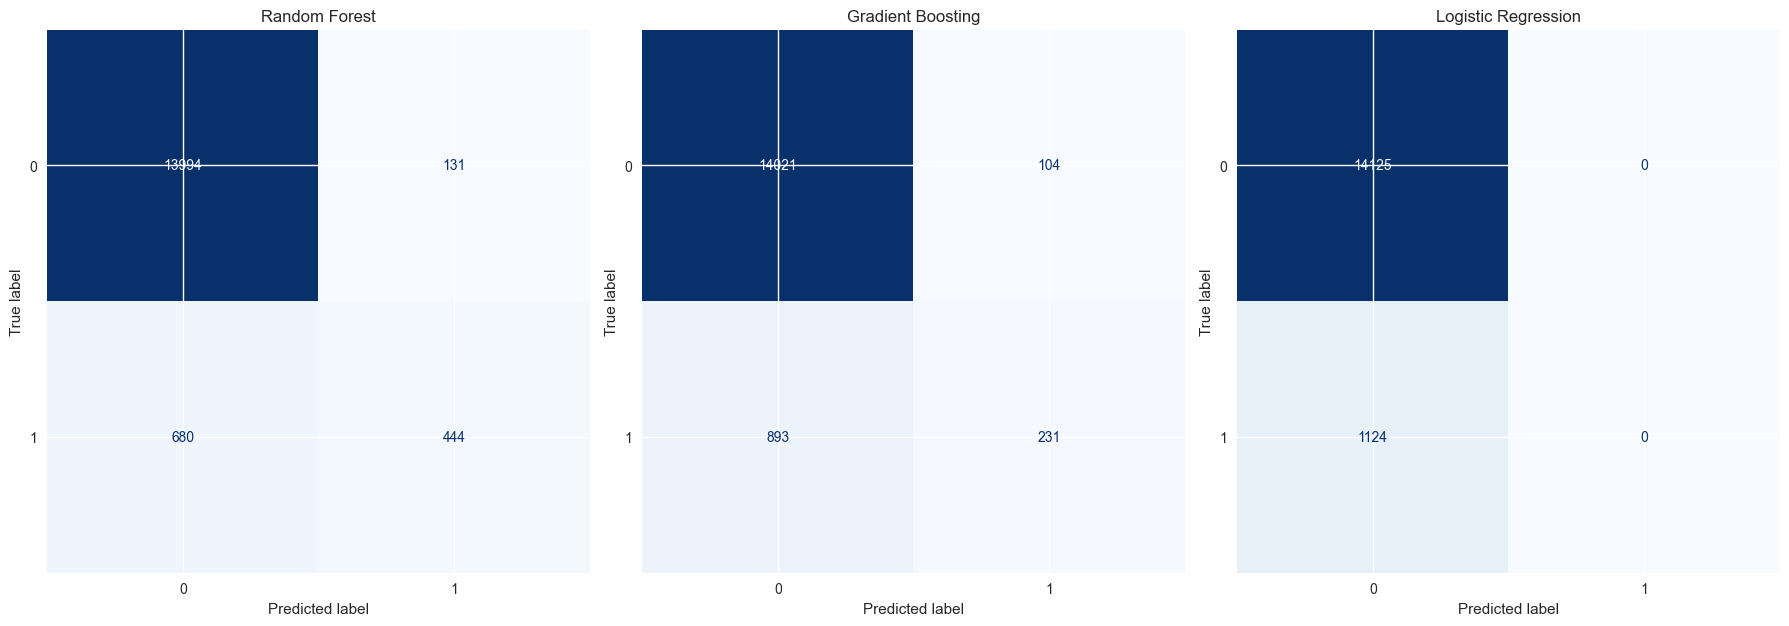

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusão - Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Random Forest')

# Matriz de confusão - Gradient Boosting
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Gradient Boosting')

# Matriz de confusão - Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, ax=axes[2], cmap='Blues', colorbar=False)
axes[2].set_title('Logistic Regression')

plt.tight_layout()
plt.show()

> Como objetivo final desse projeto, é possível observar que o modelo Random Forest performou melhor observando a quantidade de registros de verdadeiros positivos, visto que é o principal objeto do estudo.

In [44]:
# Previsão de probabilidades com Random Forest
prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilidade de inadimplência (classe 1)

# Previsão de probabilidades com Gradient Boosting
prob_gb = gb_model.predict_proba(X_test)[:, 1]  # Probabilidade de inadimplência (classe 1)

# Previsão de probabilidades com Logistic Regression
prob_log = log_model.predict_proba(X_test)[:, 1]  # Probabilidade de inadimplência (classe 1)

# Adicionando as probabilidades ao DataFrame de teste
df_probabilidades = X_test.copy()
df_probabilidades['Probabilidade_RF'] = prob_rf
df_probabilidades['Probabilidade_GB'] = prob_gb
df_probabilidades['Probabilidade_Log'] = prob_log

print("Probabilidades de inadimplência calculadas com sucesso!")
print(df_probabilidades.head())

Probabilidades de inadimplência calculadas com sucesso!
       VALOR_A_PAGAR  TAXA  MES_VENCIMENTO  ANO_VENCIMENTO  \
63421       22289.16  5.99             1.0          2021.0   
42161      140971.60  8.99             3.0          2020.0   
56408       26125.87  5.99            11.0          2020.0   
658         59829.50  5.99             9.0          2018.0   
75086       38892.60  4.99             6.0          2021.0   

       DIA_SEMANA_VENCIMENTO  RENDA_MES_ANTERIOR  SEGMENTO_INDUSTRIAL_encoded  \
63421                    3.0            194354.0                            0   
42161                    0.0            650493.0                            0   
56408                    2.0            316604.0                            1   
658                      0.0            240562.0                            0   
75086                    1.0            312165.0                            0   

       PORTE_encoded  VALOR_CATEGORIA_encoded  TAXA_CATEGORIA_encoded  \
63421      

## 8. Análise de Importância das Features

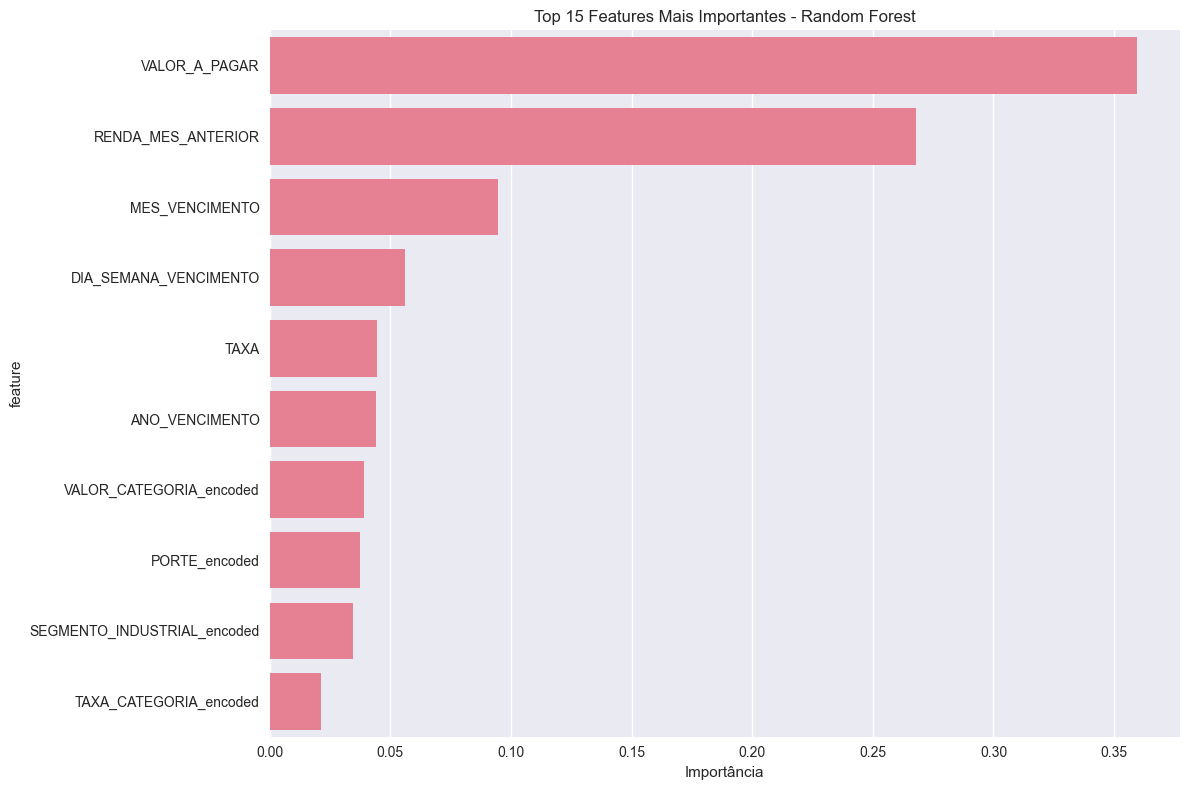

Top 10 features mais importantes (Random Forest):
                       feature  importance
0                VALOR_A_PAGAR    0.359328
5           RENDA_MES_ANTERIOR    0.268026
2               MES_VENCIMENTO    0.094517
4        DIA_SEMANA_VENCIMENTO    0.056328
1                         TAXA    0.044601
3               ANO_VENCIMENTO    0.044237
8      VALOR_CATEGORIA_encoded    0.039238
7                PORTE_encoded    0.037665
6  SEGMENTO_INDUSTRIAL_encoded    0.034603
9       TAXA_CATEGORIA_encoded    0.021457


In [45]:
# Importância das features com o melhor modelo (Random Forest)
feature_importance_rf = pd.DataFrame({
    'feature': features_finais,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_rf.head(15), x='importance', y='feature')
plt.title('Top 15 Features Mais Importantes - Random Forest')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

print("Top 10 features mais importantes (Random Forest):")
print(feature_importance_rf.head(10))

## 9. Preparação dos Dados de Teste para Predição

In [46]:
# Preparando dados de teste para predição
df_teste_processed = df_teste.copy()

# Convertendo datas
df_teste_processed['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_teste_processed['DATA_EMISSAO_DOCUMENTO'])
df_teste_processed['DATA_VENCIMENTO'] = pd.to_datetime(df_teste_processed['DATA_VENCIMENTO'])

# Criando features temporais
df_teste_processed['MES_VENCIMENTO'] = df_teste_processed['DATA_VENCIMENTO'].dt.month
df_teste_processed['ANO_VENCIMENTO'] = df_teste_processed['DATA_VENCIMENTO'].dt.year
df_teste_processed['DIA_SEMANA_VENCIMENTO'] = df_teste_processed['DATA_VENCIMENTO'].dt.dayofweek

# Features de valor e taxa usando qcut para criar faixas com quantis
df_teste_processed['VALOR_CATEGORIA'] = pd.qcut(
    df_teste_processed['VALOR_A_PAGAR'],
    q=5,
    labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']
)

df_teste_processed['TAXA_CATEGORIA'] = pd.qcut(
    df_teste_processed['TAXA'],
    q=3,
    labels=['Baixo', 'Médio', 'Alto']
)

print("Dados de teste processados com sucesso!")
print(f"Shape: {df_teste_processed.shape}")

Dados de teste processados com sucesso!
Shape: (12275, 11)


In [47]:
# Merge com dados cadastrais e info
df_teste_final = df_teste_processed.merge(df_cadastral, on='ID_CLIENTE', how='left')
df_teste_final = df_teste_final.merge(df_info, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')

# Selecionando features para predição
features_teste = ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO',
                  'SEGMENTO_INDUSTRIAL', 'PORTE', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA']

# Adicionando features de informação mensal se disponíveis
if 'RENDA_MES_ANTERIOR' in df_teste_final.columns:
    features_teste.append('RENDA_MES_ANTERIOR')

print(f"Features para predição: {features_teste}")
print(f"Shape final dos dados de teste: {df_teste_final.shape}")

Features para predição: ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO', 'SEGMENTO_INDUSTRIAL', 'PORTE', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA', 'RENDA_MES_ANTERIOR']
Shape final dos dados de teste: (12275, 20)


## 10. Predições nos Dados de Teste

In [48]:
# Preparando dados de teste para predição
df_teste_model = df_teste_final[features_teste].copy()

# Tratamento de missing values
imputer_numerico_teste = SimpleImputer(strategy='median')
imputer_categorico_teste = SimpleImputer(strategy='most_frequent')

# Separando features numéricas e categóricas
features_numericas_teste = ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO']
features_categoricas_teste = ['SEGMENTO_INDUSTRIAL', 'PORTE', 'VALOR_CATEGORIA', 'TAXA_CATEGORIA']

# Adicionando features de informação mensal se disponíveis
if 'RENDA_MES_ANTERIOR' in df_teste_model.columns:
    features_numericas_teste.append('RENDA_MES_ANTERIOR')

# Aplicando imputação
df_teste_model[features_numericas_teste] = imputer_numerico_teste.fit_transform(df_teste_model[features_numericas_teste])
df_teste_model[features_categoricas_teste] = imputer_categorico_teste.fit_transform(df_teste_model[features_categoricas_teste])

# Encoding de variáveis categóricas
for col in features_categoricas_teste:
    if col in label_encoders:
        df_teste_model[col + '_encoded'] = label_encoders[col].transform(df_teste_model[col].astype(str))
    else:
        # Se não temos o encoder, criamos um novo
        le = LabelEncoder()
        df_teste_model[col + '_encoded'] = le.fit_transform(df_teste_model[col].astype(str))

# Criando lista final de features para teste
features_finais_teste = features_numericas_teste + [col + '_encoded' for col in features_categoricas_teste]

print(f"Features finais para teste: {features_finais_teste}")
print(f"Shape dos dados de teste processados: {df_teste_model.shape}")

Features finais para teste: ['VALOR_A_PAGAR', 'TAXA', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO', 'RENDA_MES_ANTERIOR', 'SEGMENTO_INDUSTRIAL_encoded', 'PORTE_encoded', 'VALOR_CATEGORIA_encoded', 'TAXA_CATEGORIA_encoded']
Shape dos dados de teste processados: (12275, 14)


In [49]:
# Fazendo predições com o melhor modelo (Random Forest Classifier)
X_teste = df_teste_model[features_finais_teste]

# Predições de inadimplência
inadimplente_previsto = rf_model.predict(X_teste)
probabilidade_inadimplencia = rf_model.predict_proba(X_teste)[:, 1]  # Probabilidade de inadimplência (classe 1)

# Adicionando predições e probabilidades ao dataset original
df_resultado_final = df_teste.copy()
df_resultado_final['INADIMPLENTE_PREVISTO'] = inadimplente_previsto
df_resultado_final['PROBABILIDADE_INADIMPLENCIA'] = probabilidade_inadimplencia

print("Predições realizadas com sucesso!")
print(f"Shape do resultado: {df_resultado_final.shape}")
print("\nDistribuição das predições de inadimplência:")
print(df_resultado_final['INADIMPLENTE_PREVISTO'].value_counts())

# Mostrando primeiros resultados
print("\nPrimeiros 10 registros com predições e probabilidades:")
display(df_resultado_final[['ID_CLIENTE', 'SAFRA_REF', 'VALOR_A_PAGAR', 'TAXA', 'INADIMPLENTE_PREVISTO', 'PROBABILIDADE_INADIMPLENCIA']].head(10))

Predições realizadas com sucesso!
Shape do resultado: (12275, 8)

Distribuição das predições de inadimplência:
INADIMPLENTE_PREVISTO
0    12242
1       33
Name: count, dtype: int64

Primeiros 10 registros com predições e probabilidades:


,ID_CLIENTE,SAFRA_REF,VALOR_A_PAGAR,TAXA,INADIMPLENTE_PREVISTO,PROBABILIDADE_INADIMPLENCIA
0,5058298901476893676,2021-07,11204.75,4.99,0,0.18
1,274692171162531764,2021-07,60718.50,5.99,0,0.02
2,274692171162531764,2021-07,60718.50,5.99,0,0.05
3,274692171162531764,2021-07,62250.00,5.99,0,0.02
4,465309249432033993,2021-07,26593.95,6.99,0,0.04
5,465309249432033993,2021-07,26012.44,6.99,0,0.05
6,465309249432033993,2021-07,26082.54,6.99,0,0.03
7,465309249432033993,2021-07,26738.12,6.99,0,0.02
8,5883155883105348987,2021-07,20260.27,8.99,0,0.04
9,5883155883105348987,2021-07,19043.82,8.99,0,0.05


=== ANÁLISE DOS RESULTADOS ===
Proporção de inadimplentes previstos: 0.27%

Distribuição das predições:
Adimplentes previstos (INADIMPLENTE_PREVISTO = 0): 12,242 (99.7%)
Inadimplentes previstos (INADIMPLENTE_PREVISTO = 1): 33 (0.3%)


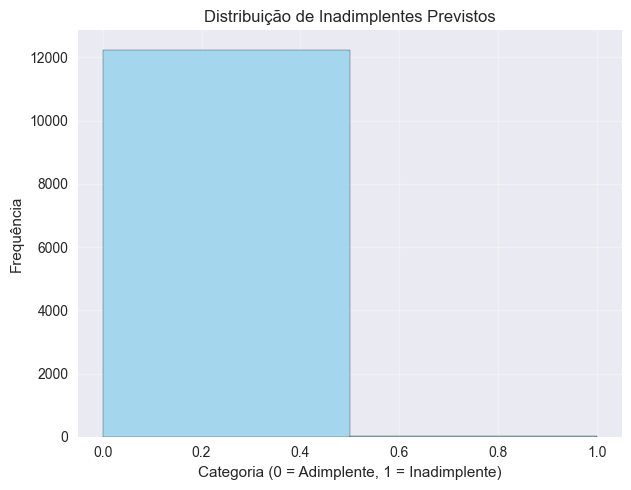

In [ ]:
print("=== ANÁLISE DOS RESULTADOS ===")
print(f"Proporção de inadimplentes previstos: {df_resultado_final['INADIMPLENTE_PREVISTO'].mean():.2%}")

# Análise da distribuição das predições
print("\nDistribuição das predições:")
print(f"Adimplentes previstos (INADIMPLENTE_PREVISTO = 0): {(df_resultado_final['INADIMPLENTE_PREVISTO'] == 0).sum():,} ({(df_resultado_final['INADIMPLENTE_PREVISTO'] == 0).mean():.1%})")
print(f"Inadimplentes previstos (INADIMPLENTE_PREVISTO = 1): {(df_resultado_final['INADIMPLENTE_PREVISTO'] == 1).sum():,} ({(df_resultado_final['INADIMPLENTE_PREVISTO'] == 1).mean():.1%})")

# Histograma das predições
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_resultado_final['INADIMPLENTE_PREVISTO'], bins=2, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição de Ina'dimplentes Previstos')
plt.xlabel('Categoria (0 = Adimplente, 1 = Inadimplente)')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [51]:
# Salvando resultados
df_resultado_final[["ID_CLIENTE", "SAFRA_REF", "PROBABILIDADE_INADIMPLENCIA"]].to_csv('./data/submissao_case.csv', index=False, sep=';')
print("Resultados salvos em './data/submissao_case.csv'")

# Resumo final
print("\n=== RESUMO FINAL ===")
print(f"Total de registros analisados: {len(df_resultado_final):,}")
print(f"Média de probabilidade de inadimplência: {df_resultado_final['PROBABILIDADE_INADIMPLENCIA'].mean():.2%}")
print(f"Máxima probabilidade de inadimplência: {df_resultado_final['PROBABILIDADE_INADIMPLENCIA'].max():.2%}")
print(f"Mínima probabilidade de inadimplência: {df_resultado_final['PROBABILIDADE_INADIMPLENCIA'].min():.2%}")

print("\nModelo de Regressão para predição de inadimplência concluído com sucesso!")
print("O arquivo 'submissao_case.csv' contém as probabilidades de inadimplência para todos os registros de teste.")

Resultados salvos em './data/submissao_case.csv'

=== RESUMO FINAL ===
Total de registros analisados: 12,275
Média de probabilidade de inadimplência: 8.17%
Máxima probabilidade de inadimplência: 66.00%
Mínima probabilidade de inadimplência: 0.00%

Modelo de Regressão para predição de inadimplência concluído com sucesso!
O arquivo 'submissao_case.csv' contém as probabilidades de inadimplência para todos os registros de teste.
